<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/Altrarete256_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:

import os
import numpy as np
from matplotlib import pyplot as plt
batch_size=3

In [3]:
train_img_path = "/gdrive/MyDrive/TESI/FOLD1/train/train_images"
train_mask_path = "/gdrive/MyDrive/TESI/FOLD1/train/train_masks"

val_img_path = "/gdrive/MyDrive/TESI/FOLD1/train/val_images"
val_mask_path = "/gdrive/MyDrive/TESI/FOLD1/train/val_masks"

In [4]:
seed=42
from keras.preprocessing.image import ImageDataGenerator


img_data_gen_args = dict(rescale=1./255,
                     rotation_range=90,

                     brightness_range=[0.3,0.9],

                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
   
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant')

mask_data_gen_args = dict(
                     rotation_range=90,
  
                     brightness_range=[0.3,0.9],

                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
           
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                
                     
                     ) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

In [5]:
batch_size=3
image_generator = image_data_generator.flow_from_directory(train_img_path, 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           color_mode = 'grayscale',
                                                           
                                                           target_size=(256,256),
                                                           
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_generator = mask_data_generator.flow_from_directory(train_mask_path, 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',

                                                         target_size=(256,256)  , #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory(val_img_path, 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale', 
                                                               
                                                               target_size=(256,256),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(256,256),
                                                               
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 2982 images belonging to 1 classes.
Found 2982 images belonging to 1 classes.
Found 477 images belonging to 1 classes.
Found 477 images belonging to 1 classes.


In [6]:
from matplotlib import pyplot as plt


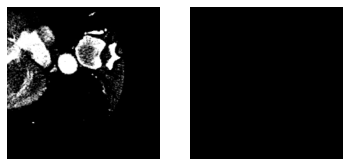

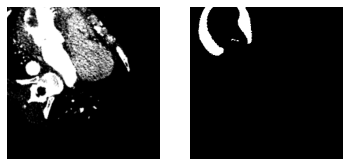

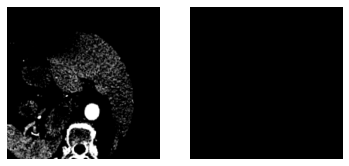

In [7]:
x, y = train_generator.__next__()

for i in range(0,3):
    image = x[i,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [8]:
x.max()


0.86274517

In [9]:
x.shape

(3, 256, 256, 1)

In [10]:
y.max()

1.0

In [11]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TESI/FOLD1/train/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TESI/FOLD1/train/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size



In [12]:
print(steps_per_epoch)

994


In [13]:

from tensorflow.keras.layers import Conv3D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten,MaxPooling3D, concatenate,UpSampling3D,Lambda,Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import models
from tensorflow.python.keras.layers import ConvLSTM2D
from keras import backend as K

In [14]:
def unet(input_size=(256,256,1)):
    N = input_size[0]

    inputs = Input(input_size)
    
    conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = layers.Dropout(0.5)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
   
    up6 = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv4_1)
    up6 = layers.BatchNormalization(axis=3)(up6)
    up6 = layers.Activation('relu')(up6)

    x1 = layers.Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = layers.Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = layers.ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
    conv6 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = layers.BatchNormalization(axis=3)(up7)
    up7 = layers.Activation('relu')(up7)

    x1 = layers.Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = layers.Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = layers.ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = layers.BatchNormalization(axis=3)(up8)
    up8 = layers.Activation('relu')(up8)    

    x1 = layers.Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = layers.Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = layers.Conv2D(1, 1, activation = 'sigmoid')(conv8)

    return Model(inputs=[inputs], outputs=[conv9])

In [15]:

model = unet(input_size=(256,256,1))
model.summary()

  <tf.Variable 'conv_lst_m2d/recurrent_kernel:0' shape=(3, 3, 32, 128) dtype=float32>
  <tf.Variable 'conv_lst_m2d/bias:0' shape=(128,) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                               

In [16]:
import tensorflow as tf

In [17]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return ((2. * intersection + smooth) / (K.sum(y_true_f) +
            K.sum(y_pred_f) + smooth))


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coefficient(y_true, y_pred)


def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [18]:
LR = 1e-4
optim = tf.keras.optimizers.Adam(LR)

In [19]:
metrics=[iou, dice_coefficient, 'binary_accuracy']

In [20]:
model.compile(optimizer=optim, loss=dice_coefficient_loss, metrics=metrics)


In [21]:
history=model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_generator,
    
          validation_steps=val_steps_per_epoch)

Epoch 1/40
994/994 [==============================] - 720s 700ms/step - loss: 0.5995 - iou: 0.3038 - dice_coefficient: 0.4005 - binary_accuracy: 0.9178 - val_loss: 0.6184 - val_iou: 0.2657 - val_dice_coefficient: 0.3816 - val_binary_accuracy: 0.9863
Epoch 2/40
994/994 [==============================] - 388s 390ms/step - loss: 0.4848 - iou: 0.3957 - dice_coefficient: 0.5152 - binary_accuracy: 0.9761 - val_loss: 0.5009 - val_iou: 0.3681 - val_dice_coefficient: 0.4991 - val_binary_accuracy: 0.9795
Epoch 3/40
994/994 [==============================] - 386s 388ms/step - loss: 0.4542 - iou: 0.4280 - dice_coefficient: 0.5458 - binary_accuracy: 0.9781 - val_loss: 0.4888 - val_iou: 0.3932 - val_dice_coefficient: 0.5112 - val_binary_accuracy: 0.9855
Epoch 4/40
994/994 [==============================] - 386s 388ms/step - loss: 0.4355 - iou: 0.4468 - dice_coefficient: 0.5645 - binary_accuracy: 0.9803 - val_loss: 0.5295 - val_iou: 0.3558 - val_dice_coefficient: 0.4705 - val_binary_accuracy: 0.9883


KeyboardInterrupt: ignored